# TP3 - Ejercicio 3
### Segmentación de Imagenes (usando SVM)

##### Enunciado:
Considere la imagen cow.jpg y las imágenes muestra: vaca.jpg, cielo.jpg y pasto.jpg correspondientes a las clases dentro de la imagen “vaca”, “cielo” y “pasto”, respectivamente.

a)  Construir un conjunto de datos para entrenamiento, indicando para cada muestra a qué clase pertenece.

b)  Dividir aleatoriamente el conjunto de datos en dos conjuntos, uno de entrenamiento y uno de prueba.

c)  Utilizar el método SVM para clasificar los pixels del conjunto de prueba, entrenando con el conjunto de entrenamiento. Utilizar diferentes núcleos y diferentes valores del parámetro C. Construir la matriz de confusión para cada caso.

d)  ¿Cuál es el núcleo que da mejores resultados? Pensar una justificación teórica para la respuesta.

e)  Con el mismo método ya entrenado clasificar todos los pixels de la imagen.

f)  Con el mismo método ya entrenado clasificar todos los pixels de otra imagen.

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.image as img
import matplotlib.pyplot as plt
from ml_tps.utils.data_processing import divide_in_training_test_datasets, scale_dataset, get_test_train_X_y
from ml_tps.utils.image_processing import read_image_to_dataframe, segment_and_draw_image
from ml_tps.utils.hyperparameter_tuning import test_svm_configurations

print("Paquetes importados.")

Paquetes importados.


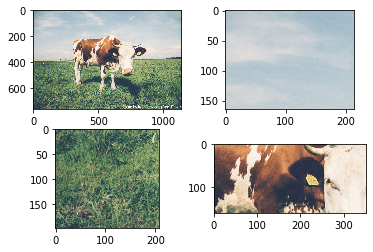

In [2]:
dir_path = os.path.dirname(os.path.realpath("e3.ipynb"))
DEFAULT_FILEPATH = f"{dir_path}/../tp3/data/"
PCTG_DATA_TO_USE = 0.1      # so that computation does not take too long, use smaller percentage of data

pictures = []
picture_names = ["cow", "cielo", "pasto", "vaca"]

for pic in picture_names:
    pictures.append(img.imread(DEFAULT_FILEPATH + pic + ".jpg"))

i = 221
for pic in pictures:
    plt.subplot(i)
    plt.imshow(pic)
    i += 1
plt.show()

In [3]:
# Data preparation
filepath_sky = DEFAULT_FILEPATH + "cielo.jpg"
filepath_cow = DEFAULT_FILEPATH + "vaca.jpg"
filepath_grass = DEFAULT_FILEPATH + "pasto.jpg"
filepath_given_test_image = DEFAULT_FILEPATH + "cow.jpg"
filepath_own_test_image = DEFAULT_FILEPATH + "field_sky_test_image.jpg"

objective_desc = "Objective"

# a)  Construir un conjunto de datos para entrenamiento, indicando para cada muestra a qué clase pertenece.
data_sky, discard_sky = divide_in_training_test_datasets(read_image_to_dataframe(filepath_sky), PCTG_DATA_TO_USE)
data_cow, discard_cow = divide_in_training_test_datasets(read_image_to_dataframe(filepath_cow), PCTG_DATA_TO_USE)
data_grass, discard_grass = divide_in_training_test_datasets(read_image_to_dataframe(filepath_grass), PCTG_DATA_TO_USE)
data_given_test_image = read_image_to_dataframe(filepath_given_test_image)
data_own_test_image = read_image_to_dataframe(filepath_own_test_image)

# Add objective columns
data_sky[objective_desc] = "Sky"
data_cow[objective_desc] = "Cow"
data_grass[objective_desc] = "Grass"

# Scale image data
data_sky = scale_dataset(dataset=data_sky, objective=objective_desc)
data_cow = scale_dataset(dataset=data_cow, objective=objective_desc)
data_grass = scale_dataset(dataset=data_grass, objective=objective_desc)
data_given_test_image = scale_dataset(dataset=data_given_test_image, objective=None)
data_own_test_image = scale_dataset(dataset=data_own_test_image, objective=None)

# Merge data for classification
merged_data = pd.concat([data_sky, data_cow, data_grass], ignore_index=True)

# b)  Divide data set into training and cross-validation (cv) set
X_train, y_train, X_cv_set, y_cv_set = get_test_train_X_y(merged_data, objective=objective_desc)

print("Datos importados y procesados.")

Datos importados y procesados.


## Parte c) - Entrenamiento con SVM
#### Matrices de confusión

In [4]:
# Part c)
kernels = ["rbf", "poly", "linear", "sigmoid"]
c_values = list(np.logspace(-3, 2, 6))

# test_svm_configurations() for classification + Confusion Matrix for each one
svm_values, best_svm = test_svm_configurations(kernels=kernels, c_values=c_values, X_train=X_train, y_train=y_train,
                                               X_cv_set=X_cv_set, y_cv_set=y_cv_set, printConfusionMatrices=True)


 ['rbf', 0.001]
Actual      Cow  Grass   Sky
Predicted                   
Cow        2806   2074  1769

 ['rbf', 0.01]
Actual      Cow  Grass   Sky
Predicted                   
Cow        2652    310   189
Grass        89   1470   400
Sky          65    294  1180

 ['rbf', 0.1]
Actual      Cow  Grass   Sky
Predicted                   
Cow        2684    131   109
Grass        82   1709   315
Sky          40    234  1345

 ['rbf', 1.0]
Actual      Cow  Grass   Sky
Predicted                   
Cow        2700    102   101
Grass        68   1760   271
Sky          38    212  1397

 ['rbf', 10.0]
Actual      Cow  Grass   Sky
Predicted                   
Cow        2713     94   101
Grass        61   1780   263
Sky          32    200  1405

 ['rbf', 100.0]
Actual      Cow  Grass   Sky
Predicted                   
Cow        2705     84   104
Grass        67   1764   163
Sky          34    226  1502

 ['poly', 0.001]
Actual      Cow  Grass  Sky
Predicted                  
Cow        1668   

#### Lista de configuraciones

In [5]:
svm_values

,Kernel,C value,Training set accuracy,CV set accuracy
0,rbf,0.001,0.425391,0.422018
1,rbf,0.010,0.794675,0.797413
2,rbf,0.100,0.867629,0.862987
3,rbf,1.000,0.889892,0.880884
4,rbf,10.000,0.893652,0.887051
5,rbf,100.000,0.903279,0.898030
6,poly,0.001,0.650120,0.657242
7,poly,0.010,0.731348,0.738006
8,poly,0.100,0.808664,0.810047
9,poly,1.000,0.814531,0.815461


## Parte d) - Comparación de núcleos
#### Núcleo que da mejores resultados (precisión)

In [6]:
kernels_average = pd.Series()
i = 0
for kernel in kernels:
    kernels_average[kernel] = svm_values[svm_values["Kernel"] == kernel]["CV set accuracy"].mean()
    i += 1

best_kernel = kernels_average.sort_values(ascending=False).head(1)

pd.DataFrame(best_kernel, columns=["Precisión"])

,Precisión
rbf,0.791397


## Parte e) - Clasificación de la imagen dada

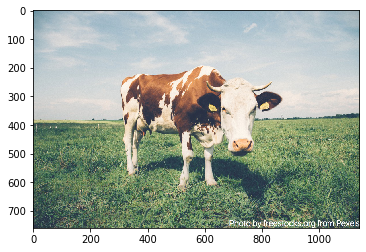

In [7]:
plt.imshow(img.imread(DEFAULT_FILEPATH + "cow.jpg"))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


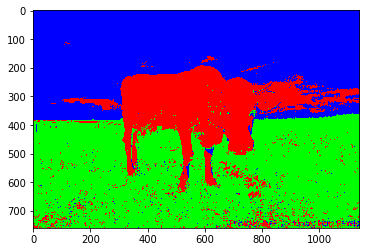

In [8]:
best_svm.fit(X_train, y_train)

red = [255, 0, 0]
green = [0, 255, 0]
blue = [0, 0, 255]
color_per_class = {"Sky": blue,
                   "Cow": red,
                   "Grass": green}

segment_and_draw_image(fitted_classifier=best_svm, image=data_given_test_image,
                       color_per_class=color_per_class, height=760, width=1140)

## Parte f) - Clasificación de otra imagen

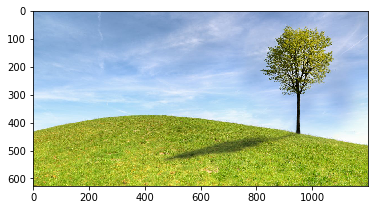

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


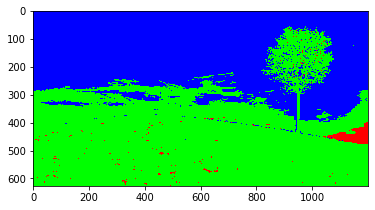

In [9]:
plt.imshow(img.imread(DEFAULT_FILEPATH + "field_sky_test_image.jpg"))
plt.show()

segment_and_draw_image(fitted_classifier=best_svm, image=data_own_test_image,
                       color_per_class=color_per_class, height=627, width=1200)